In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os.path

%matplotlib inline

# Physical constants

In [53]:
q0 = 1.6e-19 # electron charge in Coulomb
eV = 1.6e-19 # electron volt in Jouls

# Hyper-parameters

In [54]:
box_size = 20 # size of the box for taking moving box average
steady_state_reached = 20 # time step in which the steady state is reached

directory = "/Users/amirhossein/research/exciton_monte_carlo"

# read the current data

current filename: /Users/amirhossein/research/exciton_monte_carlo/region_current.dat
particle current density[m^-2*second^-1] = 5.03e+28


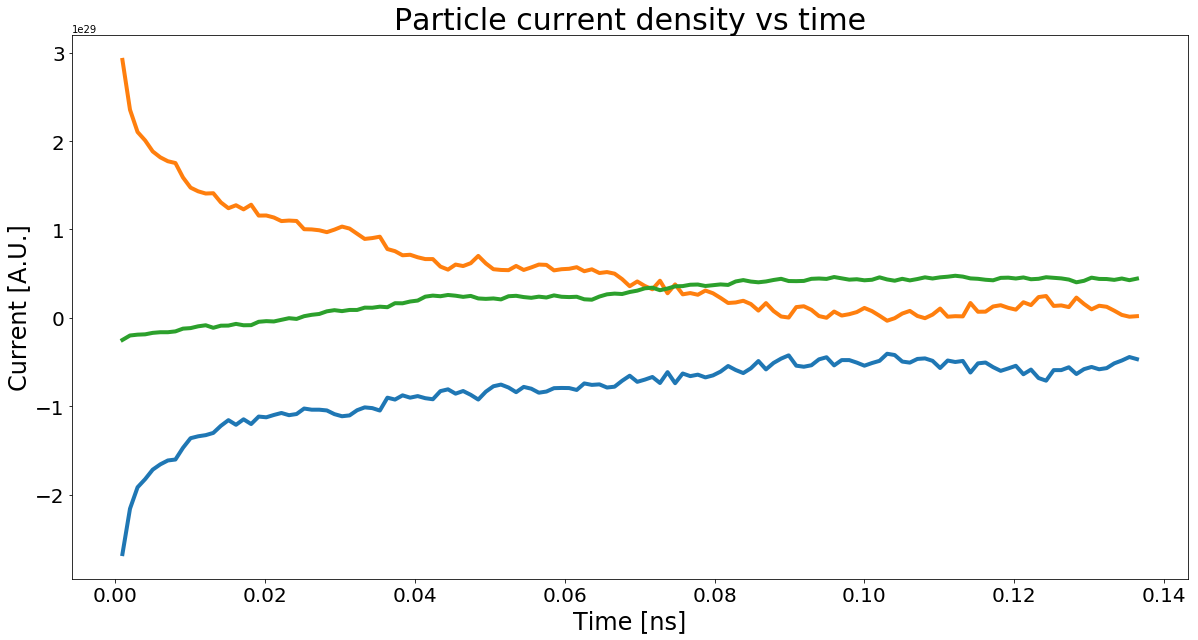

In [55]:
filename = os.path.join(directory, "region_current.dat")
print("current filename: {}".format(filename))


current = np.loadtxt(filename)
time = current[:,0]
current = current[:,1:]

# calculate and plot box average of the data
box = np.ones(box_size)
smooth_current = np.zeros((current.shape[0]-box.shape[0]+1,current.shape[1]))
for i in range(0,current.shape[1]):
    smooth_current[:,i] = np.convolve(current[:,i], box, mode='valid')/np.sum(box)
    
plt.figure(figsize=(20,10))
plt.plot(time[:smooth_current.shape[0]]*1.e9,smooth_current, linewidth=4)
plt.title("Particle current density vs time",fontsize=30)
plt.xlabel("Time [ns]",fontsize=24)
plt.ylabel("Current [A.U.]",fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)

assert (current.shape[0] > steady_state_reached), "size of current array is smaller than parameter steady_state_reached"
avg_current = np.mean(current[steady_state_reached:,:],0)
avg_current = np.mean([abs(avg_current[0]), abs(avg_current[-1])])

print("particle current density[m^-2*second^-1] = {:0.2e}".format(avg_current))

# Population profile

population profile filename: /Users/amirhossein/research/exciton_monte_carlo/population_profile.dat
gradient of population density [m^-4] = 1.3216198003172146e+32
diffusion coefficient [m^2/second] = 0.00038045262107064937


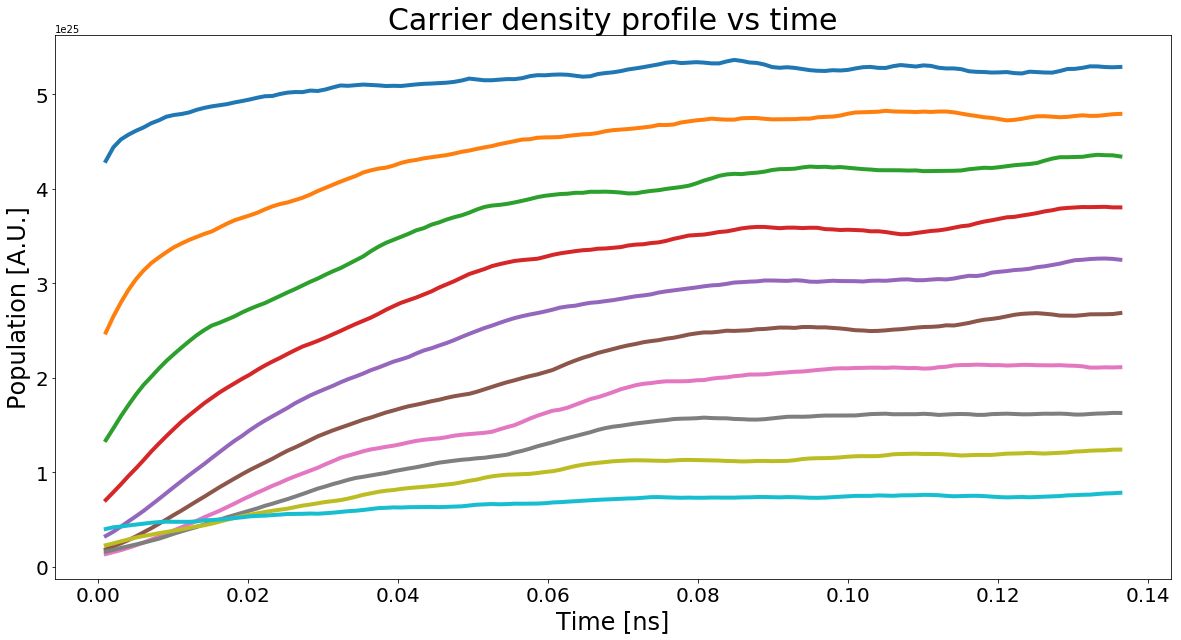

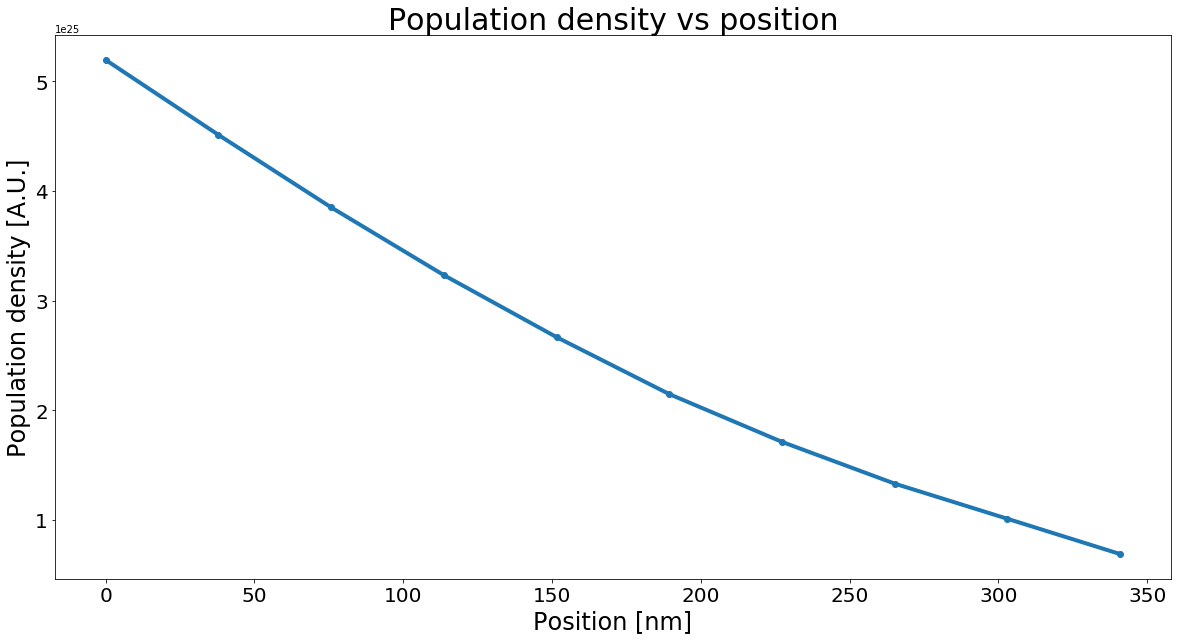

In [56]:
# directory = "/Users/amirhossein/research/exciton_monte_carlo"
filename = os.path.join(directory,"population_profile.dat")
print("population profile filename: {}".format(filename))

population = np.loadtxt(filename)
distance = population[0,1:]
time = population[1:,0]
population = population[1:,1:]

box = np.ones(box_size)
smooth_population = np.zeros((population.shape[0]-box.shape[0]+1,population.shape[1]))
for i in range(0,population.shape[1]):
    smooth_population[:,i] = np.convolve(population[:,i], box, mode='valid')/np.sum(box)

plt.figure(figsize=(20,10))
plt.plot(time[:smooth_population.shape[0]]*1.e9,smooth_population, linewidth=4)
plt.title("Carrier density profile vs time",fontsize=30)
plt.xlabel("Time [ns]",fontsize=24)
plt.ylabel("Population [A.U.]",fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)

avg_population = np.mean(population[steady_state_reached:,:],0)
plt.figure(figsize=(20,10))
plt.plot(distance*1.e9, avg_population, linewidth=4, marker='o')
plt.title("Population density vs position", fontsize=30)
plt.xlabel("Position [nm]",fontsize=24)
plt.ylabel("Population density [A.U.]",fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)

grad_population = abs((avg_population[0]-avg_population[-1])/(distance[-1]-distance[0]))
print("gradient of population density [m^-4] = {}".format(grad_population))
print("diffusion coefficient [m^2/second] = {}".format(avg_current/grad_population))

# plt.show()


# Plot current data for multiple simulations

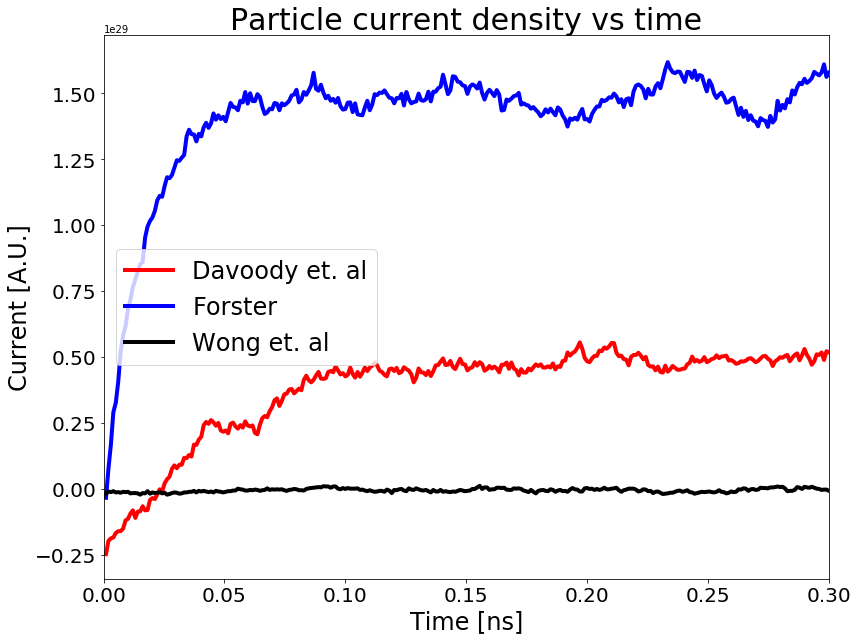

In [101]:
def plot_current(directory, box_size=20,color=None):
    filename = os.path.join(directory, "region_current.dat")
    current = np.loadtxt(filename)
    time = current[:,0]
    current = current[:,1:]
    
    assert (current.shape[0] > box_size), "box_size must be smaller than the number of time steps: {}".format(current.shape[0])

    # calculate and plot box average of the data
    box = np.ones(box_size)
    smooth_current = np.zeros((current.shape[0]-box.shape[0]+1,current.shape[1]))
    for i in range(0,current.shape[1]):
        smooth_current[:,i] = np.convolve(current[:,i], box, mode='valid')/np.sum(box)
        
    plt.plot(time[:smooth_current.shape[0]]*1.e9,(smooth_current[:,2]), linewidth=4, color=color)
    plt.title("Particle current density vs time",fontsize=30)
    plt.xlabel("Time [ns]",fontsize=24)
    plt.ylabel("Current [A.U.]",fontsize=24)
    plt.xticks(fontsize=20, rotation=0)
    plt.yticks(fontsize=20, rotation=0)
    plt.xlim([0,0.3])
#     plt.ylim([-2e29,2e29])

plt.figure(figsize=(13,10))

box_size = 20

plot_current("/Users/amirhossein/research/exciton_monte_carlo_davoody", box_size, color="red")
plot_current("/Users/amirhossein/research/exciton_monte_carlo_forster", box_size, color="blue")
plot_current("/Users/amirhossein/research/exciton_monte_carlo_wong", box_size, color="black")

plt.legend(["Davoody et. al", "Forster", "Wong et. al"], fontsize=24)

In [102]:
import numpy as np
import bqplot.pyplot as plt

size = 100

plt.figure(title='Scatter plot with colors')
plt.scatter(np.random.randn(size), np.random.randn(size), color=np.random.randn(size))
plt.show()

/Users/amirhossein/anaconda/envs/py35/lib/python3.5/site-packages/bqplot/pyplot.py:603: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  issubdtype(dtype, Scale.scale_types[key].dtype)


VBox(children=(Figure(axes=[Axis(scale=LinearScale()), ColorAxis(scale=ColorScale()), Axis(orientation='vertical', scale=LinearScale())], fig_margin={'top': 60, 'right': 60, 'left': 60, 'bottom': 60}, layout=Layout(min_width='125px'), marks=[Scatter(color=array([-1.72705493e-01,  3.48369495e-01,  9.78908377e-01,  5.24618137e-01,
        3.11059410e-01,  1.14965622e+00,  2.29115434e+00,  2.36489035e-01,
        6.35906405e-01, -2.21794635e-01,  7.09347355e-01,  1.13097191e+00,
        1.31901975e+00,  2.90148653e-01,  9.35109032e-01,  2.16325856e+00,
       -6.52013546e-01, -1.20942468e+00, -5.17461930e-01, -8.78563671e-01,
        4.66569121e-01, -1.27359699e-01, -2.02906918e+00, -1.00943044e+00,
       -2.16907473e+00, -2.74674923e-02, -4.50367351e-03,  3.47947297e-01,
       -8.83092872e-01, -4.26126693e-01, -3.40305782e-01,  4.61971771e-01,
       -3.33362486e-01,  3.91399890e-01, -3.17414627e-01,  1.39232865e+00,
       -3.33106614e-01,  6.32959325e-01,  9.60178148e-02, -1.41709668e+00,
       -1.56138969e+00, -3.28740566e-01, -2.21546077e+00,  3.49541205e-01,
        9.64784093e-01,  1.03022721e+00, -9.46153082e-01, -8.39362301e-01,
       -1.10384680e+00, -3.44178459e-01, -5.85678062e-02,  1.70883482e+00,
        1.08976817e+00, -2.20977012e+00, -1.85222341e+00,  3.79376943e+00,
        3.43263099e-01, -7.33988301e-01, -6.85324340e-01,  9.32400621e-01,
        2.52065278e+00, -8.45396500e-01,  1.71591717e+00, -5.22691362e-01,
       -1.22562367e+00, -1.76746109e+00, -1.31502133e+00,  1.05398523e-01,
       -1.43344838e-03,  2.22691880e+00,  2.68858201e+00, -9.50289446e-01,
       -4.66871803e-01,  1.01266211e+00,  1.09867657e+00, -6.75487886e-01,
        3.99605620e-01,  4.92012628e-01, -1.19497393e+00,  1.59204014e+00,
       -1.17865158e+00,  5.64727007e-02,  1.72171320e+00, -2.08051558e-01,
       -7.30907082e-01,  5.88715187e-01,  1.11827588e+00,  6.65342581e-01,
        3.40328055e-01, -2.57187918e-01,  1.74062178e+00, -1.51022095e+00,
       -1.10108888e+00, -8.03680910e-01,  9.95892938e-01, -5.97202631e-01,
        5.48521499e-01,  8.12362450e-03,  7.13532269e-01,  3.46602630e-01]), colors=['steelblue'], interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'color': ColorScale(), 'y': LinearScale()}, scales_metadata={'x': {'dimension': 'x', 'orientation': 'horizontal'}, 'skew': {'dimension': 'skew'}, 'size': {'dimension': 'size'}, 'rotation': {'dimension': 'rotation'}, 'opacity': {'dimension': 'opacity'}, 'color': {'dimension': 'color'}, 'y': {'dimension': 'y', 'orientation': 'vertical'}}, tooltip_style={'opacity': 0.9}, x=array([-1.30490707,  1.56453404,  1.71433818,  0.95019105, -0.30228294,
        2.07577213, -1.10197478,  1.21734193, -2.6029237 , -0.98209609,
        0.53419995,  0.30745691,  0.08990337, -1.79637342,  0.07147027,
       -0.03843118, -0.01297405, -1.31040102,  1.31180331, -0.53017881,
        0.11113473,  0.29889935,  0.84009163, -0.86551329,  0.3873709 ,
        0.22112792,  0.29394951, -0.23362046,  2.0246218 , -0.19228942,
        0.66751038, -0.03231014,  0.04113298, -1.14199353, -0.21034446,
        1.10499504,  0.30382136, -0.09323469,  0.90293971, -0.32868865,
        0.27868209,  0.61678176,  0.21831179, -1.8097169 , -0.33852476,
        1.09183943, -0.58062537, -0.70262489,  0.04333722, -0.0233301 ,
        0.27153798, -1.15052925,  0.02018449, -1.63915087, -0.38720765,
       -0.16183367,  0.57590355, -1.21935524, -0.51701563,  0.37287444,
        0.95367138,  0.66497082, -0.23819678,  0.93952774,  1.15765191,
       -1.58937465, -0.69799099, -0.24299975,  0.82725899, -0.20232612,
       -0.32759171,  0.45342875,  0.51068824,  0.60453454, -0.62259632,
        0.9202402 , -1.33967143, -0.80672529, -0.28192292, -0.87625111,
       -1.08373348, -0.51397901, -1.55723751,  0.74227554,  0.04750414,
        0.26173948,  0.23127889,  1.55560168,  0.61120833,  0.14785419,
       -0.39317711,  1.09773258, -0.52961996, -0.98986622,  0.30185481,
        0.48406117,  1.33067133,  0.97297